**부동산 가격 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「Feature Selection」
* 🥇Session 3 - 「TabNe, XGBoost, MLP 활용 소득 예측」

In [596]:
# Tabnet 설치
!pip install pytorch-tabnet

In [597]:
# 초기설정

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

> **데이터**
* 주택 관련 데이터
* 데이터 명세 ⬇
* https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 주택 매입 시 적정 금액 산정 어려움
```  

> **기대효과**

```
▶ 주태 매입 시 표준금액(base-line) 활용 및 적정 금액으로 매수
```

> **해결방안**

```
▶ 주택 가격 예측 모델링을 통한 적정 주택 가격 산정
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 유의미한 변수를 찾는 Feature Selection
▶ Session 3 🥇
 - TabNet 알고리즘 사용 부동산 가격 예측 모델링 수행
```

> **성과측정**  

```
▶ 모델 운용 전/후 평균 부동산(동일 범주의 건물) 매입 가격 비교
```

> **현업적용**  

```
▶ 부동산 매입 시 매입 가격 선정 시 활용
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)

In [598]:
# ▶ pd.set option
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
solution_df = pd.read_csv('solution.csv')

In [599]:
# MLP Model 초기 설정
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import random
import torch.backends.cudnn as cudnn

# 랜덤변수 고정
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [600]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<Axes: xlabel='SalePrice', ylabel='Density'>

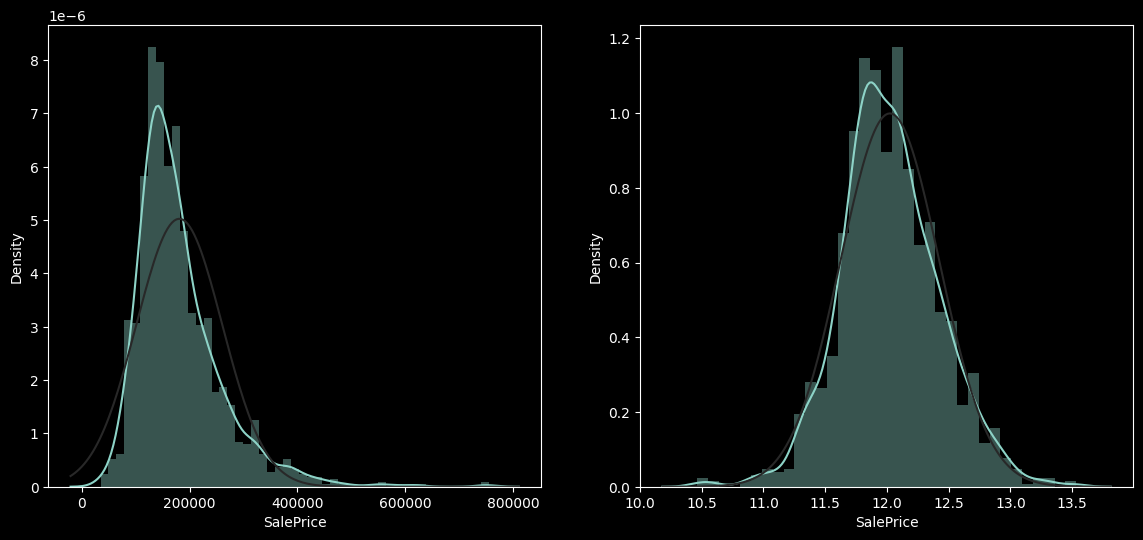

In [601]:
# 타겟 데이터 분포 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train_df['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(train_df['SalePrice']+1), fit=norm, ax=ax2)

In [602]:
# test_df left join solution_df
test_df = pd.merge(test_df, solution_df, how='left', on='Id')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500.0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500.0


In [603]:
# train concat test data Concat
df = pd.concat([train_df, test_df],axis=0)
df.shape

(2919, 81)

In [604]:
# 데이터 형태 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [605]:
# 결측치 확인
print(df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [606]:
# ▶ numeric, categorical value 나누기
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

categorical_list : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical_list : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageA

In [607]:
# ▶ 숫자형 변수에 경우 평균 값을 대체, 문자형 변수의 경우 'None'로 대체
# ▶ n_features 변환
df[numerical_list] = df[numerical_list].apply(lambda x: x.fillna(x.mean()),axis=0)

# ▶ c_features 변환
df[categorical_list] = df[categorical_list].apply(lambda x: x.fillna('None'),axis=0)

In [608]:
# Null 값 재 확인
df.isnull().sum().sum()

0

In [609]:
# ▶ Outlier 확인
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180707.333333
std,842.787043,42.517628,21.312345,7886.996359,1.409947,1.113131,30.291442,20.894344,178.626089,455.532750,169.176615,439.468337,440.690726,392.362079,428.701456,46.396825,506.051045,0.524556,0.245603,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,24.867762,0.761494,215.357904,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79970.412811
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,730.500000,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.500000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129325.000000
50%,1460.000000,50.000000,69.305795,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,369.000000,0.000000,467.000000,990.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.113406,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213495.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


## **🥈Session 2**  
**┗ Feature Selection & EDA**  
---

### · 숫자형 변수와 타겟 관계 탐색
---
* corr() 활용 상관관계 분석

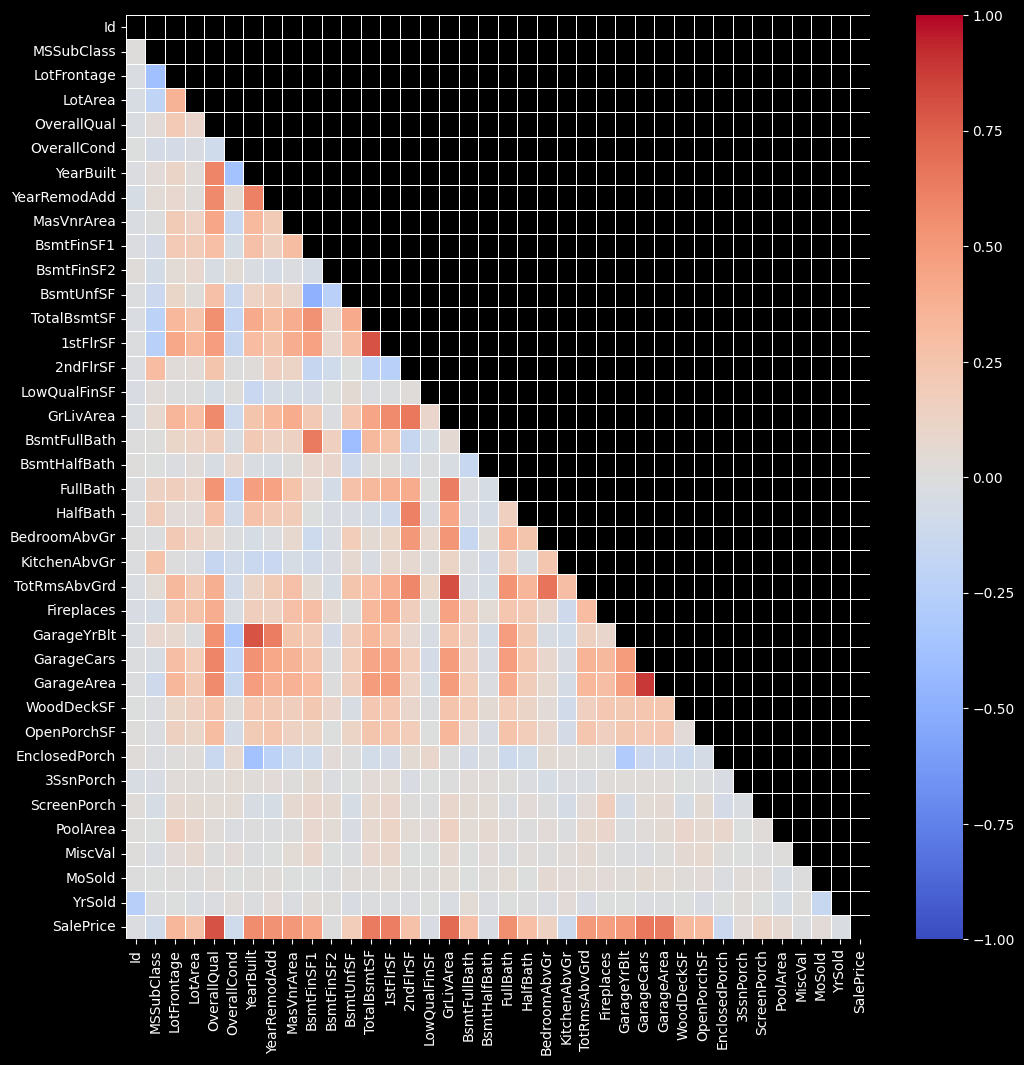

In [610]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])


# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(12,12))
df_num = df[numerical_list].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', linewidths=.5,mask=np.triu(df_num.corr()));

In [611]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
df_corr_y = pd.DataFrame(df_num['SalePrice'].sort_values(ascending=False))
df_corr_y

,SalePrice
SalePrice,1.000000
OverallQual,0.800888
GrLivArea,0.708096
GarageCars,0.649497
GarageArea,0.641731
TotalBsmtSF,0.633055
1stFlrSF,0.621541
YearBuilt,0.558433
FullBath,0.548138
YearRemodAdd,0.533158


In [612]:
# ▶ 피어슨 상관계수 절대값 기준 0.4 초과 Selection
df_corr_y[abs(df_corr_y['SalePrice']) > 0.4].index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

In [613]:
# 최종 선택 numerical feature
n_features = list(df_corr_y[abs(df_corr_y['SalePrice']) > 0.4].index)
print(n_features)

['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFinSF1']


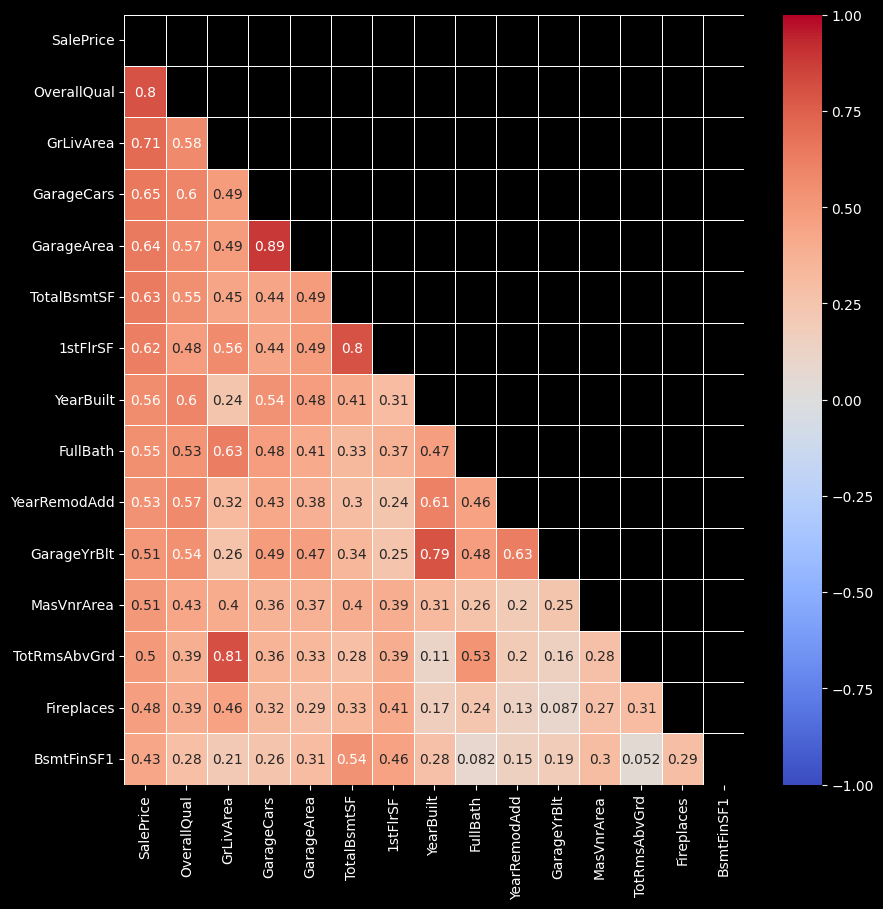

In [614]:
# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(10,10))
df_num = df[n_features].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, mask=np.triu(df_num.corr()));

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

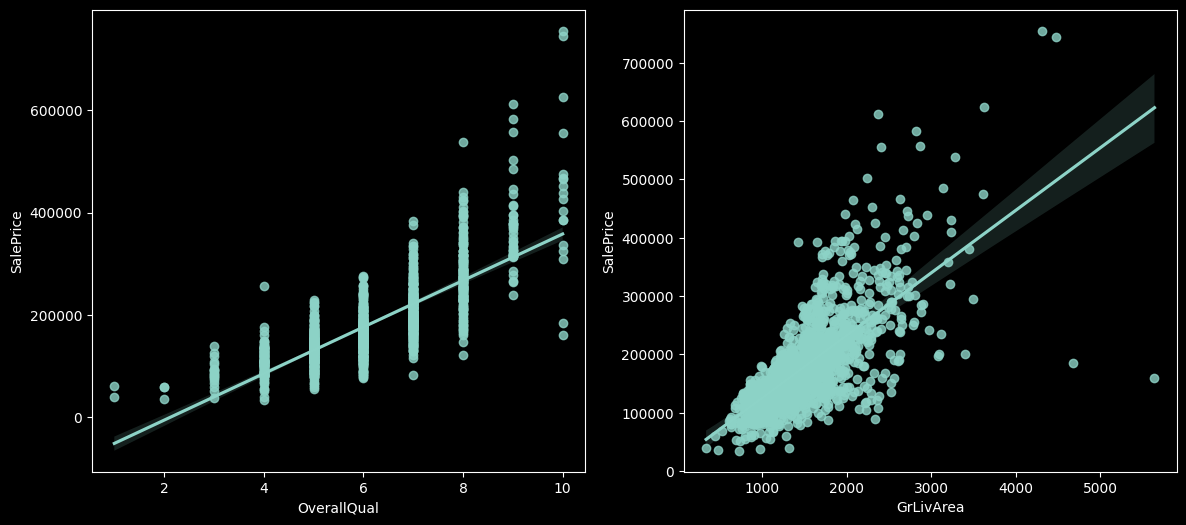

In [615]:
# corr top 2개 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)

sns.regplot(x=train_df['OverallQual'], y=train_df['SalePrice'],ax=ax1)
sns.regplot(x=train_df['GrLivArea'], y=train_df['SalePrice'],ax=ax2)

In [616]:
# 오른쪽 아래 Outlier 제거
train_df=train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

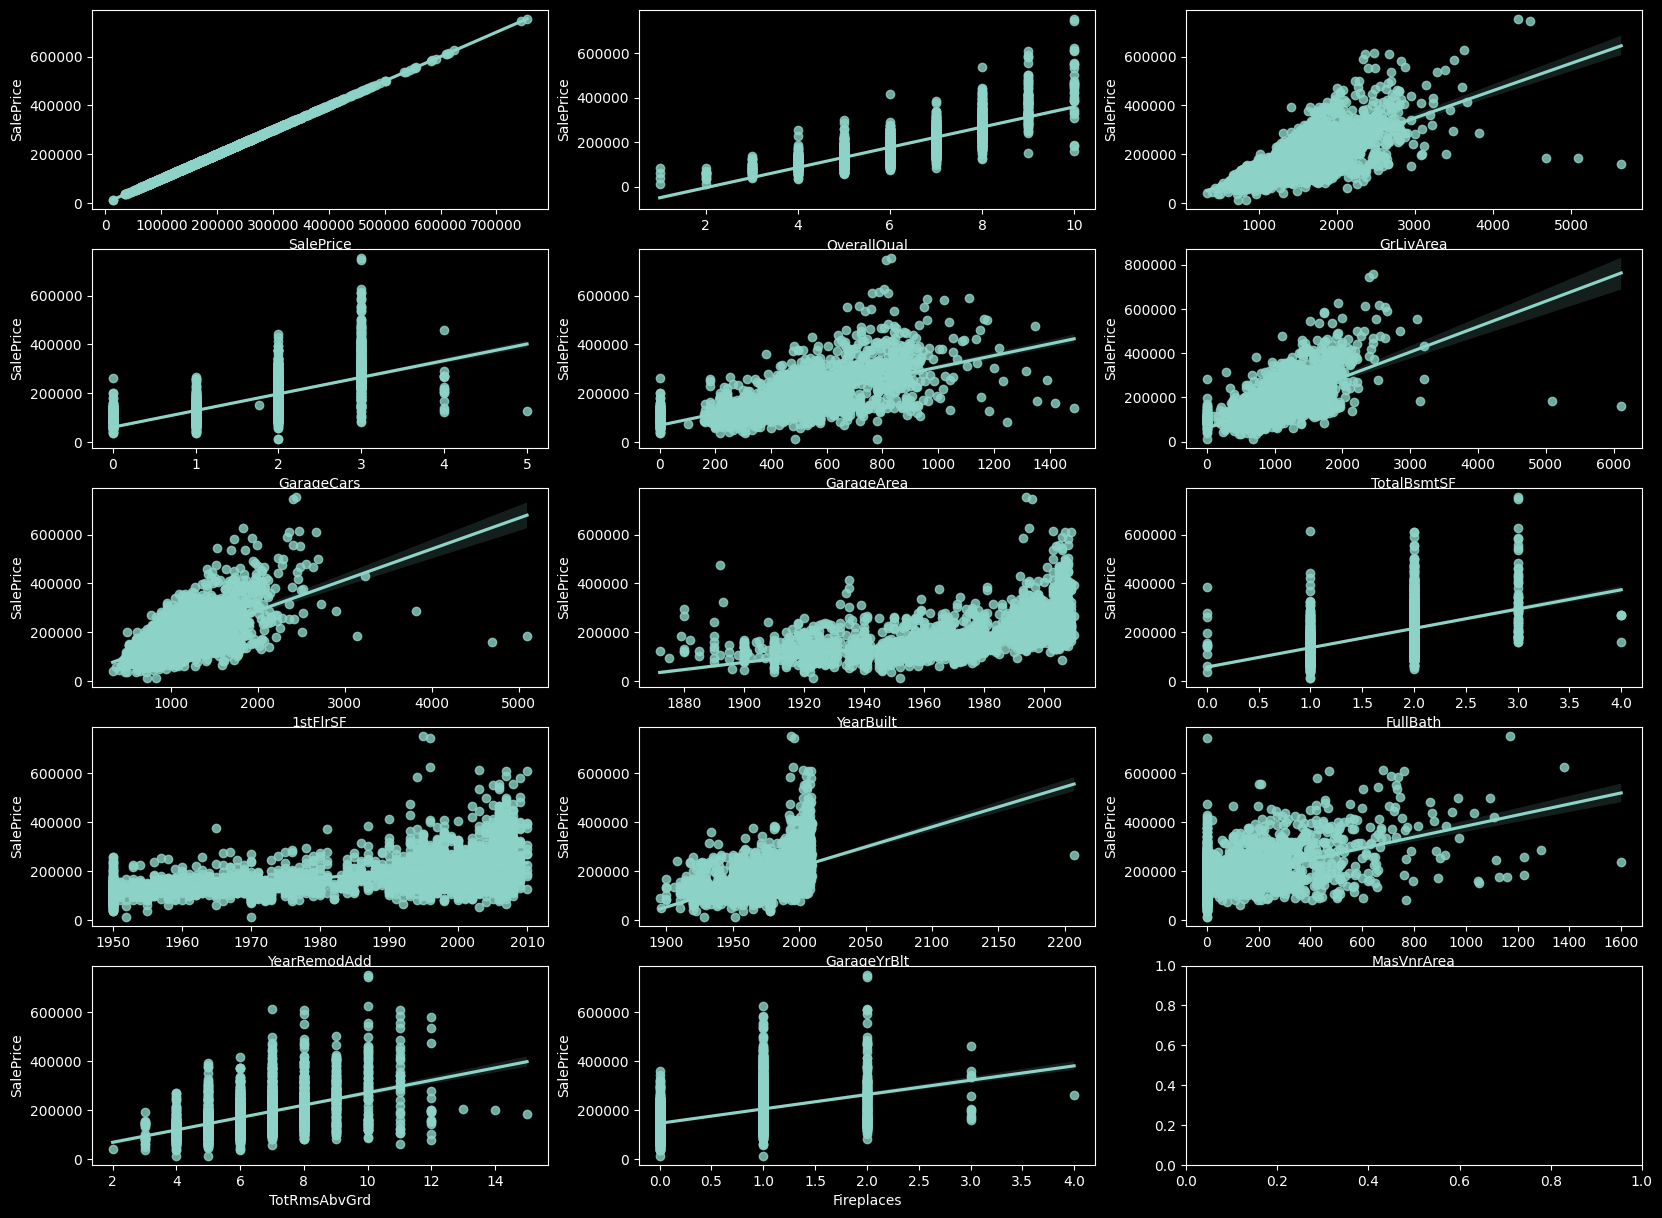

In [617]:
# 선택한 숫자형 데이터 분포 확인

fig, ax = plt.subplots(round(len(n_features) / 3), 3, figsize = (20, 15))

for i, ax in enumerate(fig.axes):
    if i < len(n_features) - 1:
        sns.regplot(x=n_features[i],y='SalePrice', data=df[n_features], ax=ax)

In [618]:
# 타겟 데이터 로그 처리 및 선정한 숫자형 데이터 분리
y_train=df['SalePrice']
y_train=np.log(y_train+1)
all_data = df
data = train_df
print(df.shape)

(2919, 81)


In [619]:
# 결측치 처리
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


In [620]:
# 전체 데이터 결측치 재확인
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

0


**┗ 가설 수립 및 검증**  
---


<Axes: ylabel='SalePrice'>

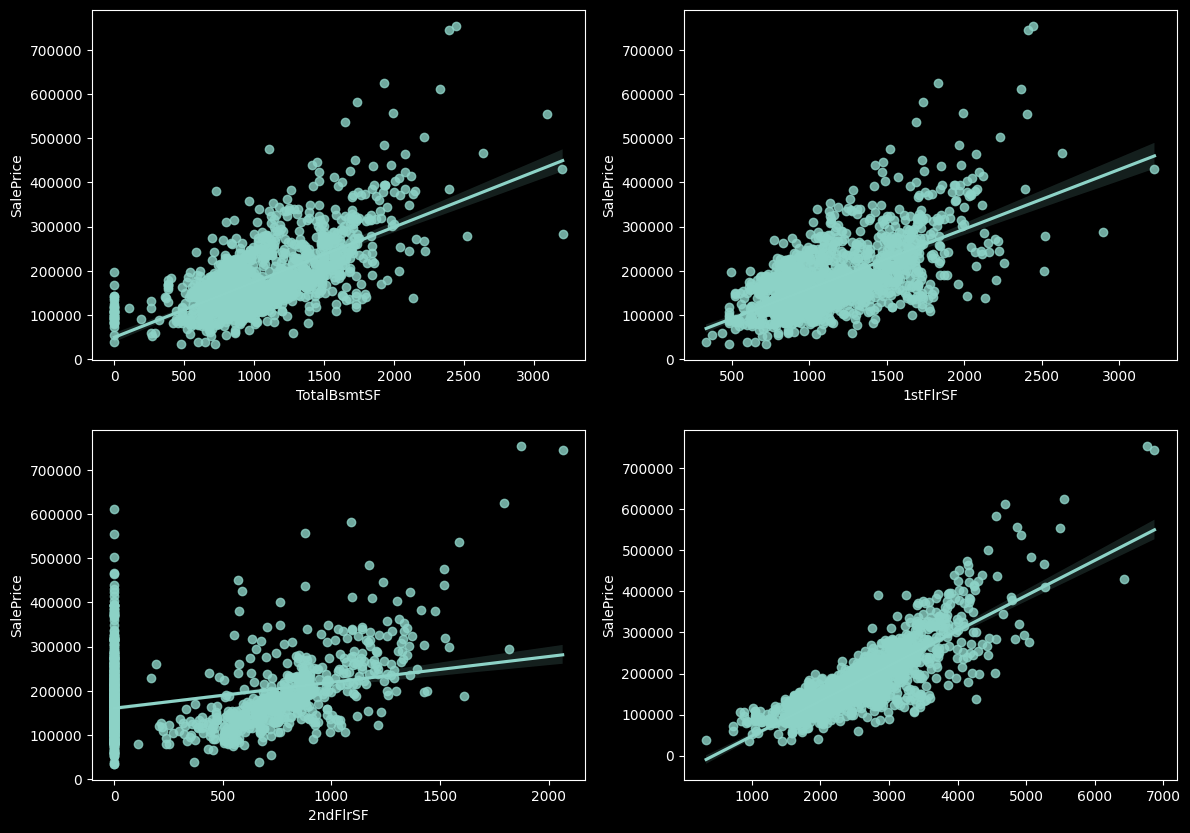

In [621]:
# ▶ (1) 총 가용 면적(Total SF Available)
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(x=data['TotalBsmtSF'], y=data['SalePrice'], ax=ax1)
sns.regplot(x=data['1stFlrSF'], y=data['SalePrice'], ax=ax2)
sns.regplot(x=data['2ndFlrSF'], y=data['SalePrice'], ax=ax3)
sns.regplot(x=(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']), y=data['SalePrice'], ax=ax4)

In [622]:
# 총가용 면적 데이터 추가
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
# all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
# all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

<Axes: ylabel='SalePrice'>

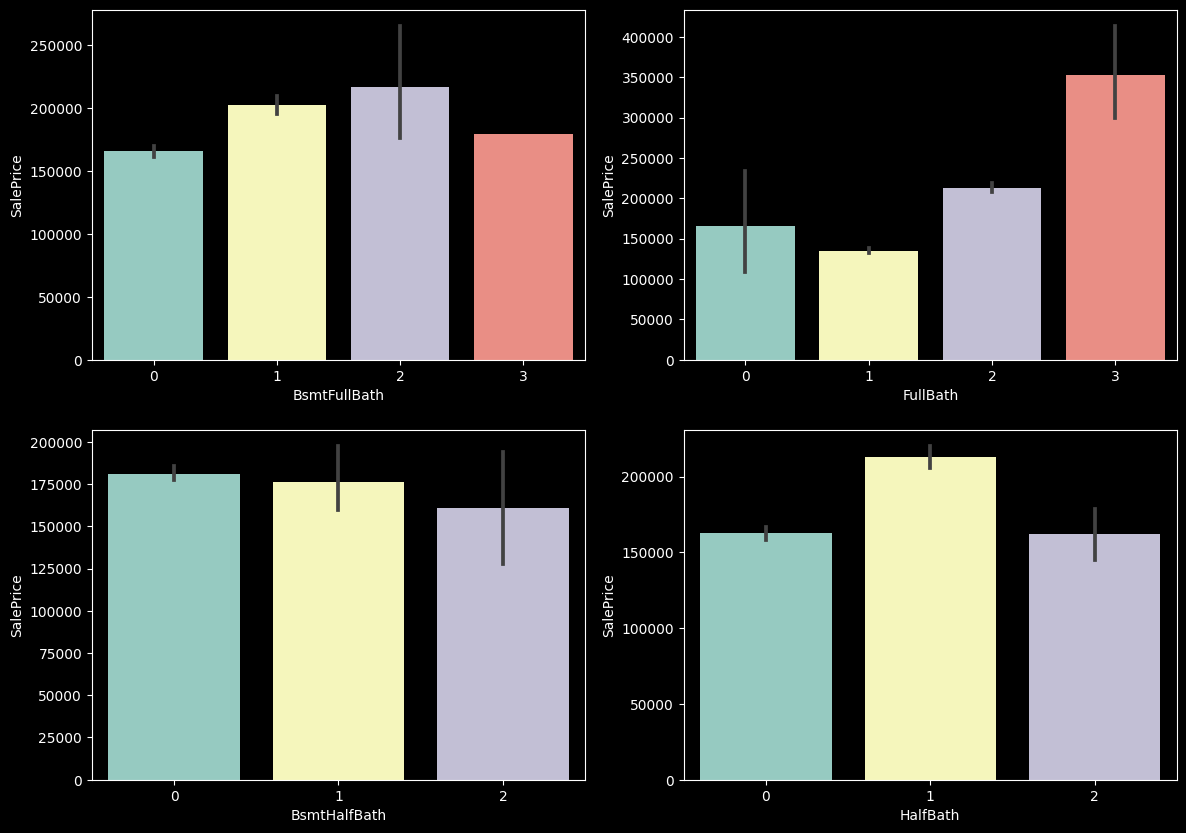

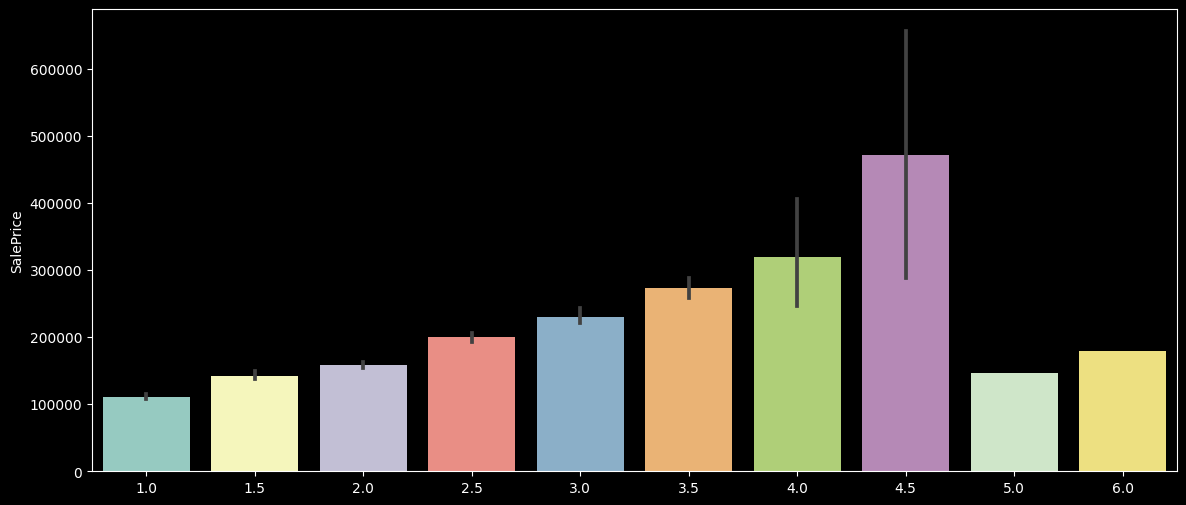

In [623]:
# ▶ (2) 총 욕실 수(Bath)
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(x=data['BsmtFullBath'], y=data['SalePrice'], ax=ax1)
sns.barplot(x=data['FullBath'], y=data['SalePrice'], ax=ax2)
sns.barplot(x=data['BsmtHalfBath'], y=data['SalePrice'], ax=ax3)
sns.barplot(x=data['HalfBath'], y=data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(x=(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2)), y=data['SalePrice'], ax=ax5)

In [624]:
# 욕실수가 많을수록 SalePrice 증가하는 경향을 보임
# 욕실수가 5개, 6개 편차가 없음 > 데이터가 하나씩만 존재 > Outlier로 판단
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

<Axes: ylabel='SalePrice'>

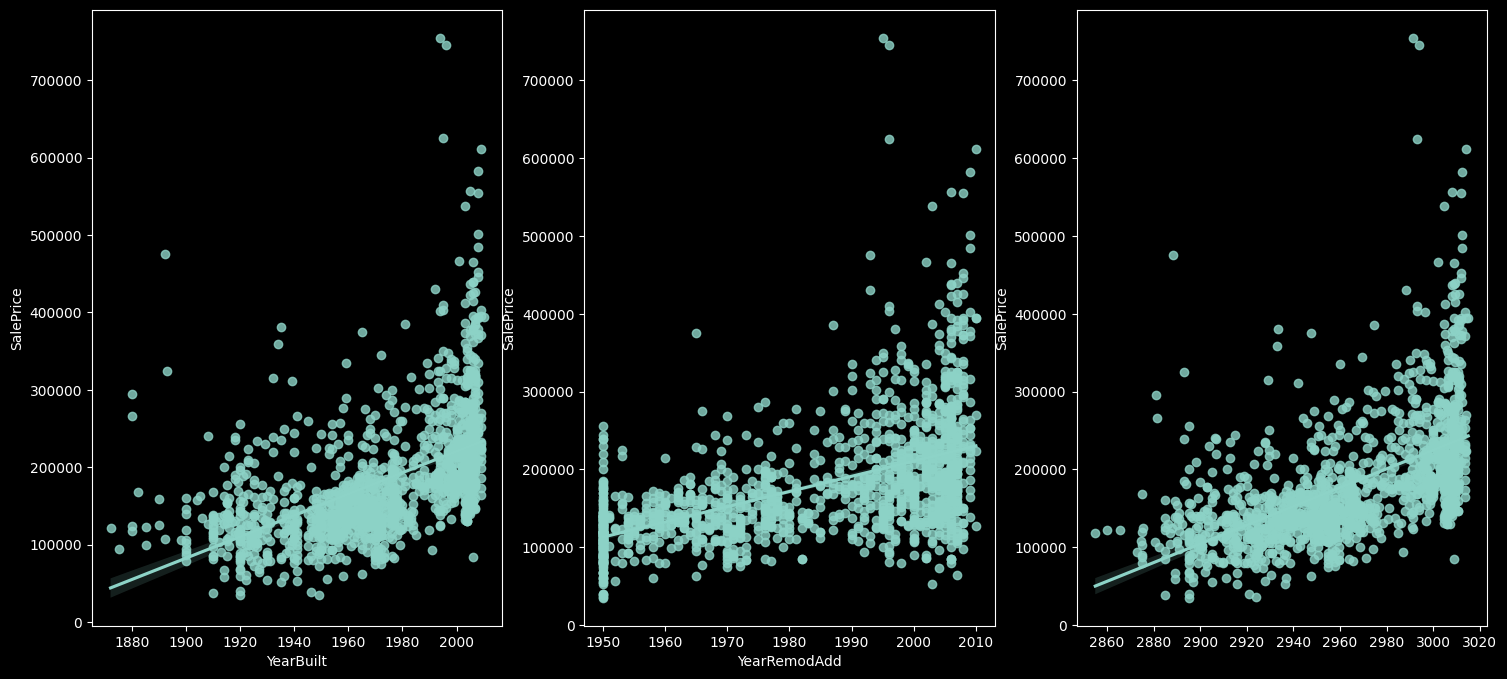

In [625]:
# ▶ (3) 건축연도 + 리모델링 연도(Year Built and Remodeled)
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(x=data['YearBuilt'], y=data['SalePrice'], ax=ax1)
sns.regplot(x=data['YearRemodAdd'], y=data['SalePrice'], ax=ax2)
sns.regplot(x=(data['YearBuilt']+ data['YearRemodAdd']/2) , y=data['SalePrice'], ax=ax3) #'/2' for graph scaling

In [626]:
# 건축연도가 오래 되었어도, 최근에 리모델링을 하면 SalePrice 높음(graph 3)
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

In [627]:
# 지하실 점수(Bsmt)
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [628]:
# 지하실 점수 숫자형 점수로 변환
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

In [629]:
# 'BsmtFinScore' 은 지하실의 완성도 점수, 'BsmtScore' 은 지하실의 종합 점수, 'BsmtDNF' 는 지하실의 미완성 여부를 나타내는 변수

Bsmt['BsmtScore']= Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore']=Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
# all_data['BsmtDNF']=(all_data['BsmtFinScore']==0)

In [630]:
# 토지 점수(Lot)
lot=['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)

all_data['LotScore']=Lot['LotScore']

In [631]:
# 차고 점수 (Garage)
garage=['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage=all_data[garage]
# all_data['NoGarage']=(all_data['GarageArea']==0)

In [632]:
# 차고 점수 숫자형 변수로 변환

Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

categorical_list : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical_list : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageA

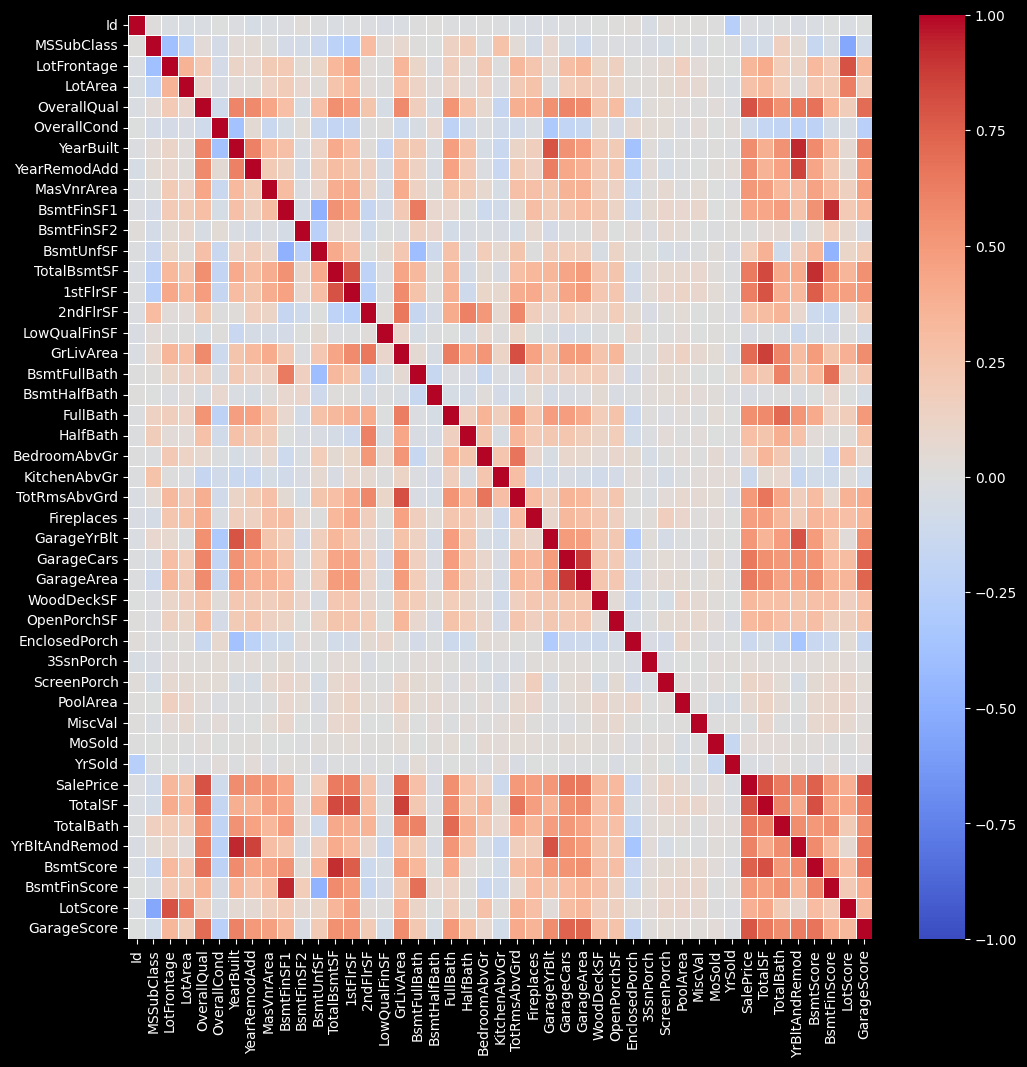

In [633]:
# ▶ corr() 활용, numerical value 추가된 데이터 상관관계 확인
# ▶ numeric, categorical value 나누기
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if all_data[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

fig = plt.figure(figsize=(12,12))
all_df_num = all_data[numerical_list].corr()
sns.heatmap(all_df_num, vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', linewidths=.5);

In [634]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
all_data_corr_y = pd.DataFrame(all_df_num['SalePrice'].sort_values(ascending=False))
all_data_corr_y

,SalePrice
SalePrice,1.000000
OverallQual,0.800888
TotalSF,0.794240
GarageScore,0.782829
BsmtScore,0.748600
GrLivArea,0.708096
GarageCars,0.649497
GarageArea,0.641731
TotalBath,0.636743
TotalBsmtSF,0.633055


In [635]:
# corr 0.4 초과 데이터
n_features = list(all_data_corr_y[abs(all_data_corr_y['SalePrice']) > 0.4].index)
print(n_features)

['SalePrice', 'OverallQual', 'TotalSF', 'GarageScore', 'BsmtScore', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBath', 'TotalBsmtSF', '1stFlrSF', 'YrBltAndRemod', 'YearBuilt', 'FullBath', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinScore', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFinSF1']


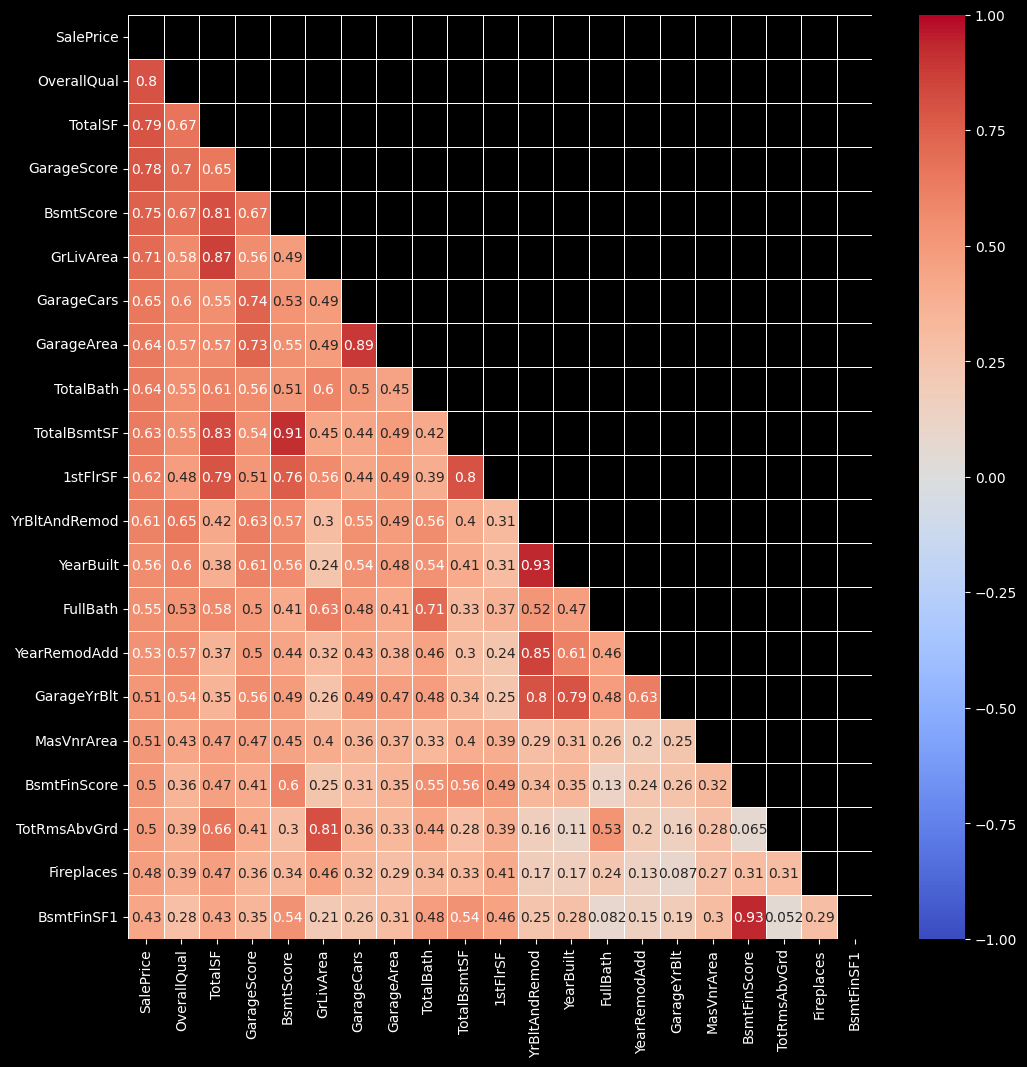

In [636]:
# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(12,12))
df_num = all_data[n_features].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, mask=np.triu(df_num.corr()));

<Axes: xlabel='PoolQC', ylabel='SalePrice'>

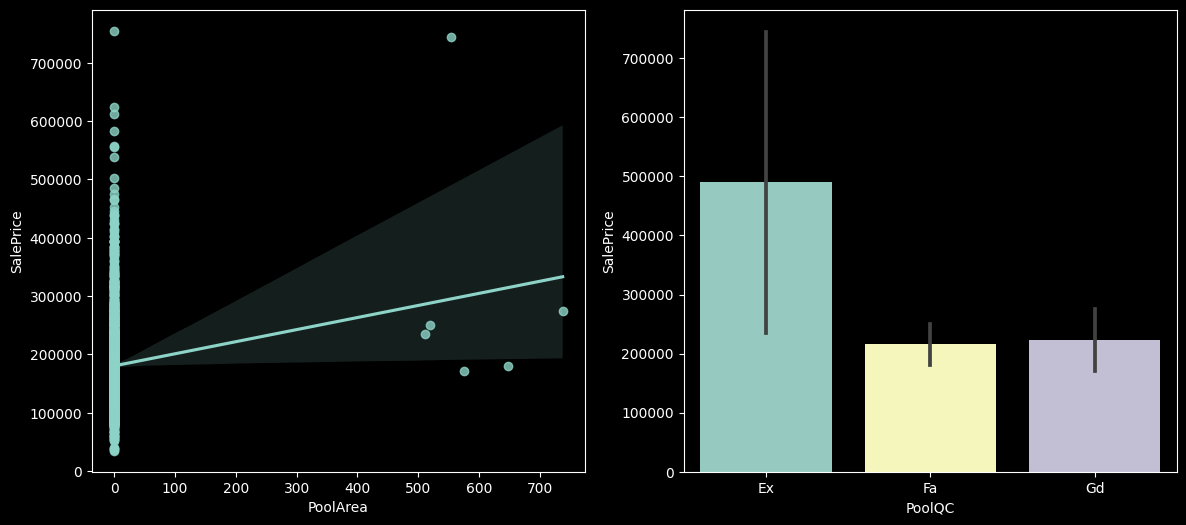

In [637]:
# 수영장 있는 집 확인
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [638]:
# 수영장이 있는 집은 매우 적으므로 삭제
all_data=all_data.drop(columns=['PoolArea','PoolQC'])
tmp = ['PoolArea','PoolQC']

# 범주형 데이터 리스트 col 삭제
for i in tmp:
  if i in categorical_list:
    categorical_list.remove(i)

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

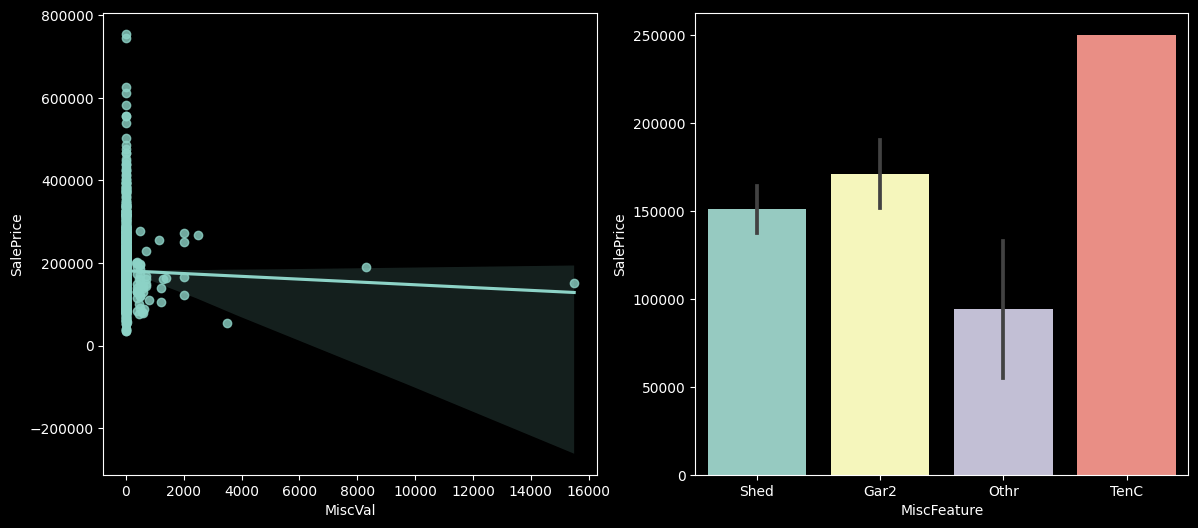

In [639]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)

In [640]:
# 테니스 코트가 있는 집의 데이터가 매우 적으므로 삭제
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

tmp = ['MiscVal','MiscFeature']

# 범주형 데이터 리스트 col 삭제
for i in tmp:
  if i in categorical_list:
    categorical_list.remove(i)

<Axes: xlabel='WoodDeckSF', ylabel='SalePrice'>

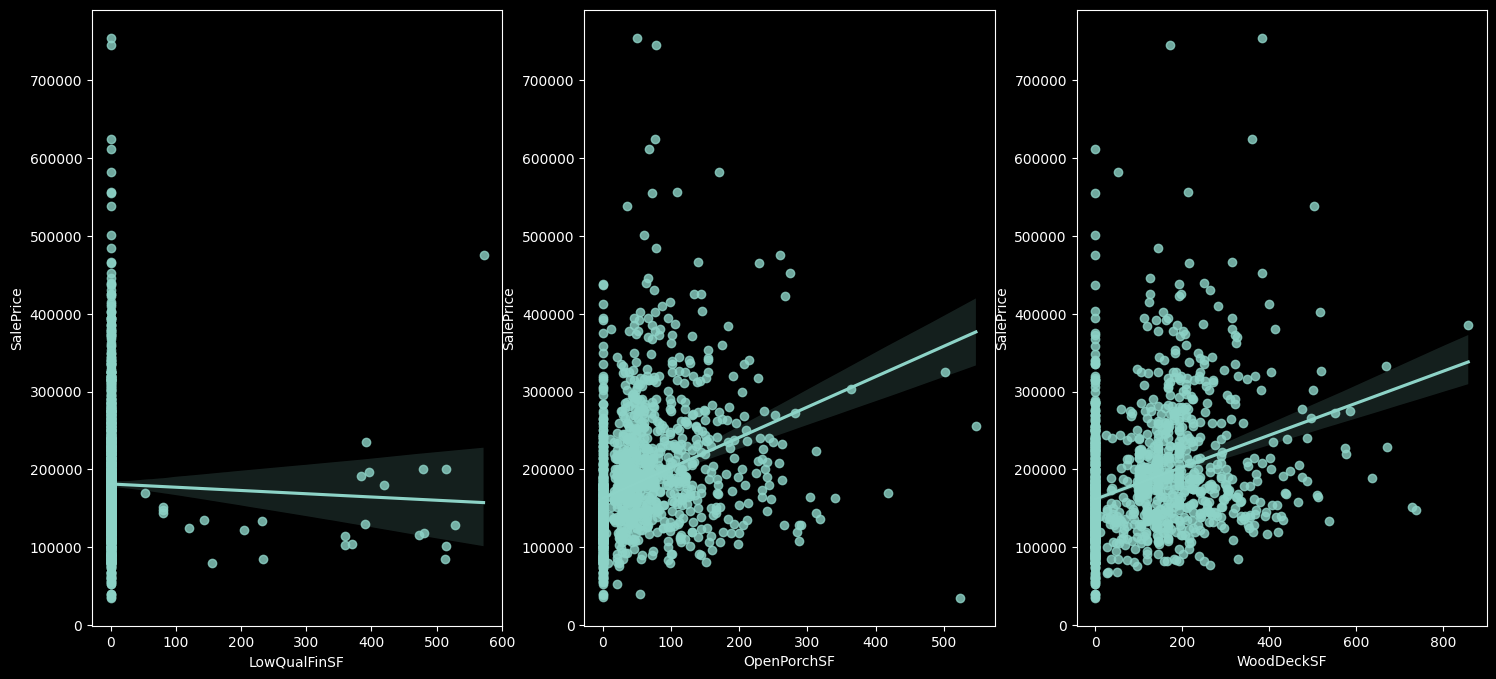

In [641]:
# 수정된 결측치가 많은 경우
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)

sns.regplot(data=data, x='LowQualFinSF', y='SalePrice', ax=ax1)
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice', ax=ax2)
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice', ax=ax3)

In [642]:
# 0인 값만 분리
# all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
# all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
# all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)

In [643]:
# 범주형 변수 확인
list_of_df = []

for var in categorical_list :
  temp = data.groupby(var)['SalePrice'].agg(['count', 'mean']).sort_values(by=['mean'], ascending=False)
  temp['lift'] = temp['mean'] / data['SalePrice'].mean()
  temp['ratio'] = round((temp['count'] / len(df))*100,2)
  print(temp)
  print('______________________________________________________________')

          count           mean      lift  ratio
MSZoning                                       
FV           65  214014.061538  1.182837   2.23
RL         1149  191037.422977  1.055847  39.36
RH           16  131558.375000  0.727111   0.55
RM          218  126316.830275  0.698142   7.47
C (all)      10   74528.000000  0.411910   0.34
______________________________________________________________
        count           mean      lift  ratio
Street                                       
Pave     1452  181142.598485  1.001159  49.74
Grvl        6  130190.500000  0.719551   0.21
______________________________________________________________
       count           mean      lift  ratio
Alley                                       
Pave      41  168000.585366  0.928524   1.40
Grvl      50  122219.080000  0.675494   1.71
______________________________________________________________
          count           mean      lift  ratio
LotShape                                       
IR2          41

In [644]:
# ▶ 의미없는 변수 삭제 결정,
categorical_list.remove('Street')
categorical_list.remove('Utilities')
categorical_list.remove('Functional')
categorical_list.remove('LandSlope')

all_data=all_data.drop(columns=['Street','Utilities', 'Functional', 'LandSlope'])

print(categorical_list)
print(len(categorical_list))

['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
37


In [645]:
# non_numeric=all_data.select_dtypes(np.object)
# c_featrues = categorical_list
# categorical_columns = []
# categricla_dims = {}

# def onehot(col_list):
#     global all_data
#     while len(col_list) !=0:
#         col=col_list.pop(0)
#         data_encoded=pd.get_dummies(all_data[col], prefix=col)
#         all_data=pd.concat([all_data, data_encoded], axis=1)
#         all_data=all_data.drop(columns=col)

#     print(all_data.shape)

# onehot(list(non_numeric))

In [646]:
# 수치형 변수 Right Skewed log 처리
def log_transform(col_list):
    for col in col_list:
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
        else:
            pass
    print(all_data.shape)

log_transform(n_features)

(2919, 80)


In [647]:
# 최종 features 리스트
features_list = n_features + categorical_list

# 최종 데이터
df = all_data[features_list]
print("학습에 사용할 feature 개수: ", len(features_list), "개")

학습에 사용할 feature 개수:  58 개


## **🥇Session 3**  
**┗ TabNet 활용 소득 예측**  
---

In [648]:
# 범주형 변수 LabelEncoding

from sklearn.preprocessing import LabelEncoder

c_features = categorical_list
categorical_columns = []
categorical_dims =  {}

for col in c_features:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

MSZoning 6
Alley 3
LotShape 4
LandContour 4
LotConfig 5
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 16
Exterior2nd 17
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 6
KitchenQual 5
FireplaceQu 6
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
Fence 5
SaleType 10
SaleCondition 6


### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [649]:
# 타켓 설정
target = 'SalePrice'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df['Set']=="train"].index
valid_indices = df[df['Set']=="valid"].index
test_indices = df[df['Set']=="test"].index

In [650]:
# ▶ Define categorical features for categorical embeddings
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
unused_feat = ['Set']
features = [ col for col in df.columns if col not in unused_feat+[target]]
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

### · 모델 학습 및 평가
---
* TabNet 모델 학습 및 평가

In [651]:
# ▶ train, valid, test data 분할
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

In [652]:
import torch
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
# ▶ cat_emb_dim : List of embeddings size for each categorical features.
from pytorch_tabnet.tab_model import TabNetRegressor
reg = TabNetRegressor(cat_dims=cat_dims,
                      cat_emb_dim=1,
                      cat_idxs=cat_idxs,
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params=dict(lr=1e-3),
                      scheduler_params={"step_size":50, "gamma":0.9},
                      scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      verbose=20)

In [653]:
# ▶ 모델 학습
max_epochs = 200
model = reg.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse', 'mae', 'rmse', 'rmsle'],
    max_epochs=max_epochs,
    drop_last=True,
    patience=200
)

epoch 0  | loss: 144.92648| train_mse: 54206.11167| train_mae: 211.01144| train_rmse: 232.82206| train_rmsle: 2.93818 | valid_mse: 54868.58719| valid_mae: 213.46056| valid_rmse: 234.24045| valid_rmsle: 2.94743 |  0:00:00s
epoch 20 | loss: 122.16062| train_mse: 1467.12245| train_mae: 24.93599| train_rmse: 38.30303| train_rmsle: 2.18661 | valid_mse: 1340.76068| valid_mae: 23.53003| valid_rmse: 36.6164 | valid_rmsle: 2.19108 |  0:00:05s
epoch 40 | loss: 100.62909| train_mse: 246.91176| train_mae: 12.96001| train_rmse: 15.71343| train_rmsle: 2.06024 | valid_mse: 226.76914| valid_mae: 12.56306| valid_rmse: 15.05886| valid_rmsle: 2.04378 |  0:00:08s
epoch 60 | loss: 80.94105| train_mse: 385.22753| train_mae: 13.76632| train_rmse: 19.62721| train_rmsle: 1.69103 | valid_mse: 355.11559| valid_mae: 13.17048| valid_rmse: 18.84451| valid_rmsle: 1.68724 |  0:00:12s
epoch 80 | loss: 61.64357| train_mse: 301.84125| train_mae: 12.33853| train_rmse: 17.37358| train_rmsle: 1.13961 | valid_mse: 252.02299

mse


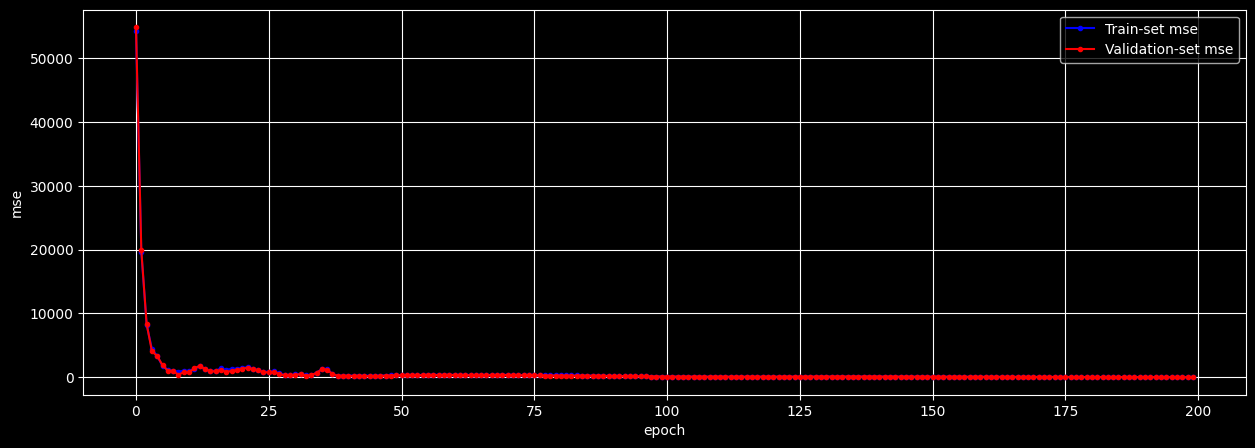

mae


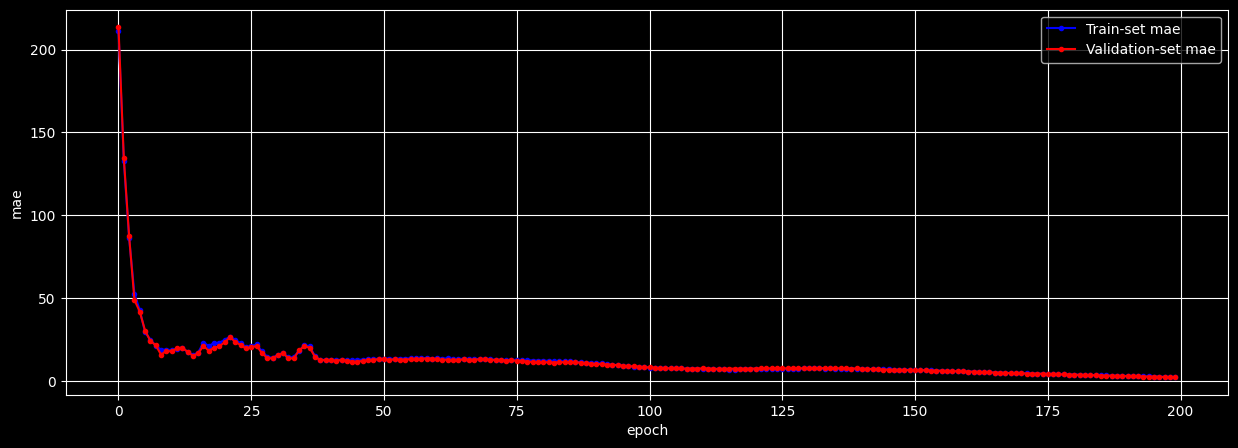

rmse


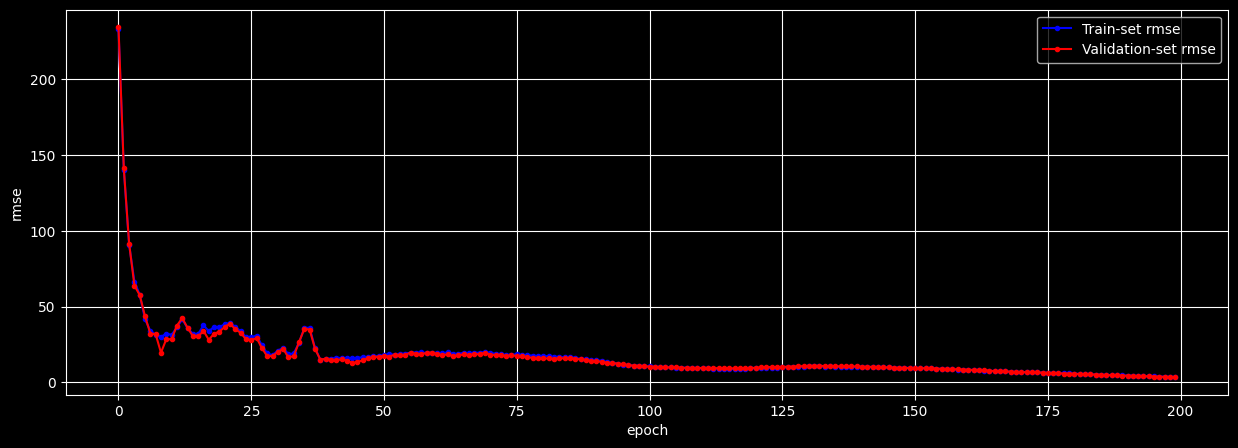

rmsle


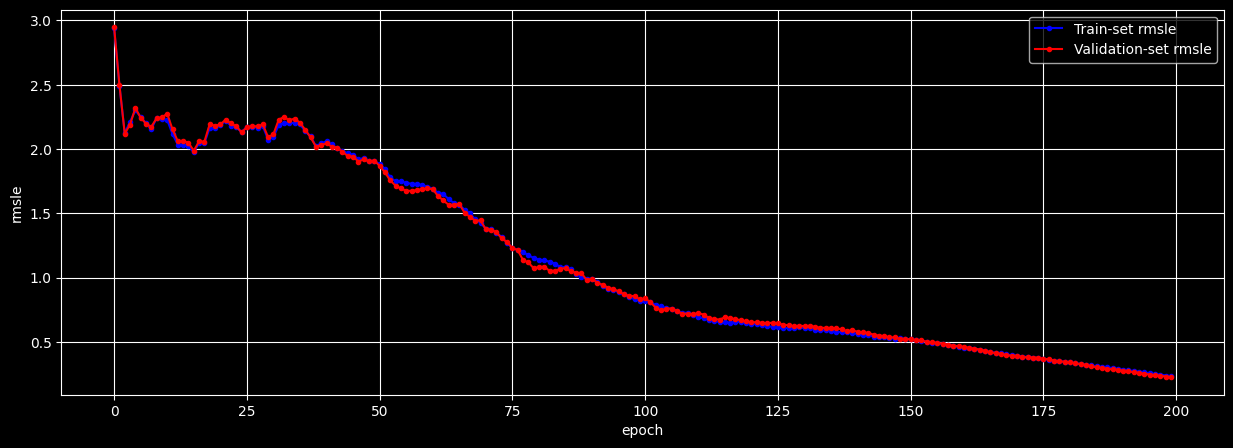

In [654]:
# error
import numpy as np
error_list = ['mse', 'mae', 'rmse', 'rmsle']

for i in error_list:
  train_error = f'train_{i}'
  val_error = f'valid_{i}'

  train_error = reg.history[train_error]
  val_error = reg.history[val_error]

  x_len = np.arange(len(val_error))
  plt.figure(figsize=(15, 5))
  plt.plot(x_len, train_error, marker='.', c='blue', label=f"Train-set {i}")
  plt.plot(x_len, val_error, marker='.', c='red', label=f"Validation-set {i}")

  plt.legend(loc='upper right')
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel(f'{i}')

  print(f"{i}")
  plt.show()

In [655]:
# ▶ TabNet test data 측정
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

pred_dict = dict()
preds = reg.predict(X_test)

pred_dict['MAE']=mean_absolute_error(y_test, preds)
pred_dict['MSE'] = mean_squared_error(y_test, preds)
pred_dict['RMSE'] = mean_squared_error(y_test, preds)**0.5
pred_dict['RSMLE'] = mean_squared_log_error(y_test, preds)**0.5

for key, value in pred_dict.items():
  print(key, ' Score:', value)

MAE  Score: 2.4836142912889274
MSE  Score: 13.279555182528021
RMSE  Score: 3.644112399820843
RSMLE  Score: 0.230544673035272


**┗ MLP 모델 예측**  

In [656]:
df = all_data[features_list]

# 범주형 변수 LabelEncoding

from sklearn.preprocessing import LabelEncoder

c_features = categorical_list
categorical_columns = []
categorical_dims =  {}

for col in c_features:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

MSZoning 6
Alley 3
LotShape 4
LandContour 4
LotConfig 5
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 16
Exterior2nd 17
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 5
BsmtCond 5
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
Heating 6
HeatingQC 5
CentralAir 2
Electrical 6
KitchenQual 5
FireplaceQu 6
GarageType 7
GarageFinish 4
GarageQual 6
GarageCond 6
PavedDrive 3
Fence 5
SaleType 10
SaleCondition 6


In [657]:
from sklearn import preprocessing

X_train = df.drop(columns='SalePrice')
y_train = df[[target]]

X_valid = df.drop(columns='SalePrice')
y_valid = df[[target]]

X_test = df.drop(columns='SalePrice')
y_test = df[[target]]

In [658]:
# Outlier 영향을 최소화하기 위해 RobustScaler 사용

scaler_x = preprocessing.RobustScaler()
X_train[X_train.columns] = scaler_x.fit_transform(X_train[X_train.columns])
X_valid[X_valid.columns] = scaler_x.transform(X_valid[X_valid.columns])
X_test[X_test.columns] = scaler_x.transform(X_test[X_test.columns])

In [659]:
X_train = X_train.values[train_indices]
y_train = y_train[target].values[train_indices].reshape(-1, 1)

X_valid = X_valid[features].values[valid_indices]
y_valid = y_valid[target].values[valid_indices].reshape(-1, 1)

X_test = X_test[features].values[test_indices]
y_test = y_test[target].values[test_indices].reshape(-1, 1)

In [660]:
# DataLoader 생성

trainX_tensor = torch.FloatTensor(X_train)
trainY_tensor = torch.FloatTensor(y_train)

valX_tensor = torch.FloatTensor(X_valid)
valY_tensor = torch.FloatTensor(y_valid)

testX_tensor = torch.FloatTensor(X_test)
testY_tensor = torch.FloatTensor(y_test)

batch = 50

train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset = TensorDataset(valX_tensor, valY_tensor)
test_dataset = TensorDataset(testX_tensor, testY_tensor)

train_dataloader = DataLoader(train_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

val_dataloader = DataLoader(val_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

test_dataloader = DataLoader(test_dataset,
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

In [661]:
n_input_dim = X_train.shape[1]

class Regressor(nn.Module):
    # ▶ 사용하기 위한 기본 함수들을 사전의 정의(self)
    def __init__(self):
        super(Regressor,self).__init__()
        self.fc1 = nn.Linear(n_input_dim, 300, bias=True)
        self.fc2 = nn.Linear(300, 100, bias=True)
        self.fc3 = nn.Linear(100, 1, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    # ▶ 순전파(forward network) 구성, forward process만 구성하면 backword는 자동을 구성됨(autograd, 자동미분)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        return x

model = Regressor()
print(model)

Regressor(
  (fc1): Linear(in_features=57, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [662]:
# model 생성
model = Regressor()

In [663]:
def train_model(model, train_df, val_df, learning_rate=None, num_epochs=None, verbose=20, patience=300):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-7)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_df))

        if val_df is not None:

            with torch.no_grad():

                val_loss = 0

                for val_batch_idx, val_samples in enumerate(val_df):

                    x_val, y_val = samples

                    val_pred = model(x_val)
                    val_step_loss = criterion(val_pred, y_val)

                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_df))


            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_df)} val loss: {val_loss / len(val_df)}')


            if (t % patience == 0) & (t != 0):


                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_df)}')


    return model, train_hist, val_hist

In [664]:
model, train_hist, val_hist = train_model(
    model,
    train_dataloader,
    val_dataloader,
    learning_rate=1e-3,
    num_epochs=200,
)

Epoch 0 train loss: 50.62835845739945 val loss: 9.019111633300781
Epoch 20 train loss: 0.8436335558476655 val loss: 0.7327885627746582
Epoch 40 train loss: 0.7925572537857554 val loss: 0.7289570569992065
Epoch 60 train loss: 0.7911101067843644 val loss: 0.7816952466964722
Epoch 80 train loss: 0.7477978202311889 val loss: 0.8470838665962219
Epoch 100 train loss: 0.6774122190216313 val loss: 0.5731916427612305
Epoch 120 train loss: 0.6477389082960461 val loss: 0.7390590906143188
Epoch 140 train loss: 0.6194889441780422 val loss: 0.5510750412940979
Epoch 160 train loss: 0.5845811801112216 val loss: 0.5807152986526489
Epoch 180 train loss: 0.5467205539993618 val loss: 0.5712941288948059


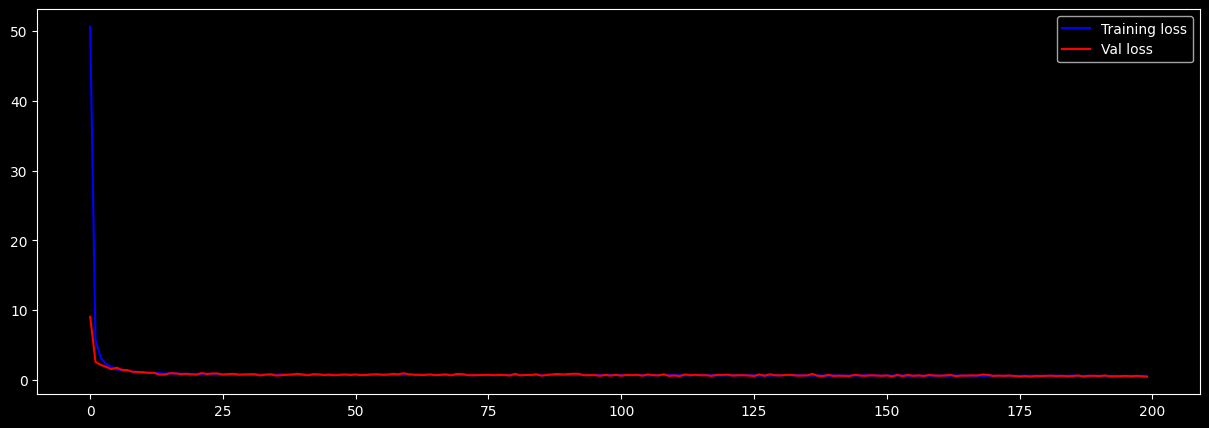

In [675]:
plt.figure(figsize=(15, 5))

plt.plot(train_hist,  c='blue', label="Training loss")
plt.plot(val_hist, c='red', label="Val loss")
plt.legend()

In [666]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model.eval()
with torch.no_grad():
    pred = []


    for test_batch_idx, test_samples in enumerate(test_dataloader):

        x_test, y_test = test_samples
        preds = model(x_test)

    print('MAE SCORE : ', mean_absolute_error(preds, y_test))
    print('MSE SCORE : ', mean_squared_error(preds, y_test))
    print('RMSE SCORE : ', mean_squared_error(preds, y_test)**0.5)
    print('MAPE SCORE : ', mean_squared_log_error(preds, y_test, )**0.5)

MAE SCORE :  0.16531771
MSE SCORE :  0.041429684
RMSE SCORE :  0.20354282980761923
MAPE SCORE :  0.016053510659597148


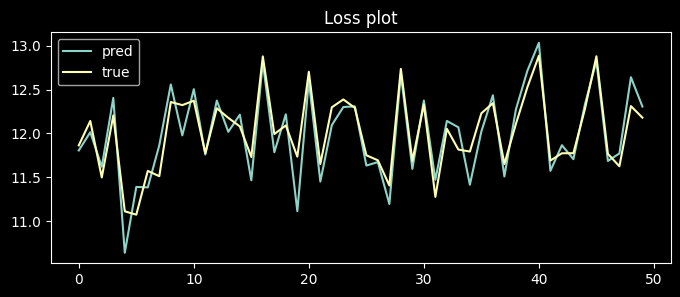

In [667]:
# ▶ train loss 출력
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(preds)), preds, label = 'pred')
plt.plot(np.arange(len(y_test)), y_test, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()

### · 변수 중요도 분석(Global, Local)


In [668]:
# ▶ train, valid, test data 재설정
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

In [ ]:
# ▶ 개별 값 변수 중요도
# ▶ 영향을 끼친 변수는 0으로 출력
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

explain_matrix, masks = reg.explain(X_test)

fig = plt.figure(figsize=(30,5));
plt.bar(features_list[1:], explain_matrix[0]);
plt.xticks(features_list[1:]);
plt.xticks(rotation=-40)

In [676]:
import plotly.express as px

# 중요도 정규화
# normalized_explain_mat = np.divide(explain_matrix, explain_matrix.sum(axis=1).reshape(-1, 1)+1e-8) # zero division error

test_preds = reg.predict(X_test)
explain_and_preds = np.hstack([explain_matrix, test_preds.reshape(-1, 1)])

px.imshow(explain_and_preds[:,:],
          labels=dict(x="Features", y="Samples", color="Local Importance"),
          x=features+["prediction"],
          title="Sample wise feature importance",
          color_continuous_scale='Jet',
          height=500)

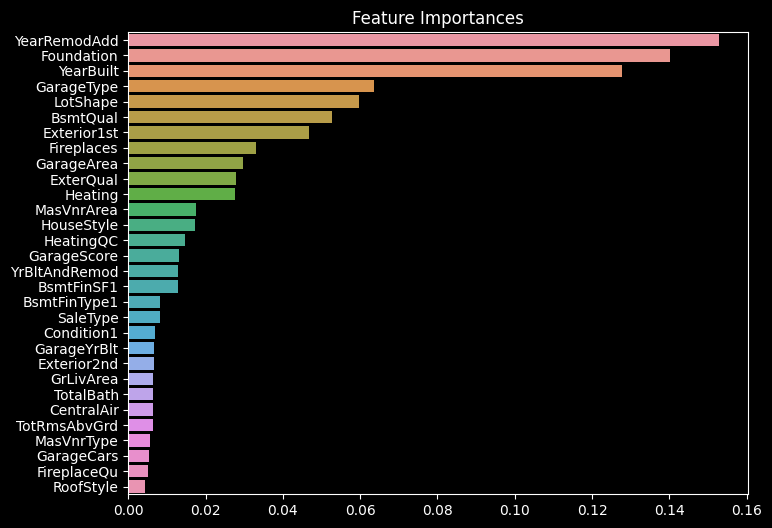

In [672]:
# ▶ Global 영향도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = features_list[1:])
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()